In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import mean_absolute_error as mae
from pandas.tseries.offsets import BDay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock Market/RELIANCE.csv')
df_main.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


In [4]:
df_main.drop(['Trades','Deliverable Volume','%Deliverble'],axis=1,inplace=True)

In [5]:
df_main.shape

(5306, 12)

In [6]:
time = pd.date_range(start='2000-01-03',periods=5306,freq=BDay())
df_main['time_stamp'] = pd.DataFrame(time)
df_main.drop(['Date'],axis=1,inplace=True)
df_main = df_main.set_index('time_stamp')

In [7]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5306 entries, 2000-01-03 to 2020-05-04
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Symbol      5306 non-null   object 
 1   Series      5306 non-null   object 
 2   Prev Close  5306 non-null   float64
 3   Open        5306 non-null   float64
 4   High        5306 non-null   float64
 5   Low         5306 non-null   float64
 6   Last        5306 non-null   float64
 7   Close       5306 non-null   float64
 8   VWAP        5306 non-null   float64
 9   Volume      5306 non-null   int64  
 10  Turnover    5306 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 497.4+ KB


In [8]:
df = df_main[['Close']]

In [9]:
df.head()

,Close
time_stamp,
2000-01-03,251.70
2000-01-04,271.85
2000-01-05,282.50
2000-01-06,294.35
2000-01-07,314.55


In [10]:
df.tail()

,Close
time_stamp,
2020-04-28,1937.85
2020-04-29,1988.65
2020-04-30,1997.30
2020-05-01,2024.05
2020-05-04,1994.50


In [11]:
plt.rcParams['figure.figsize'] = [15,8]

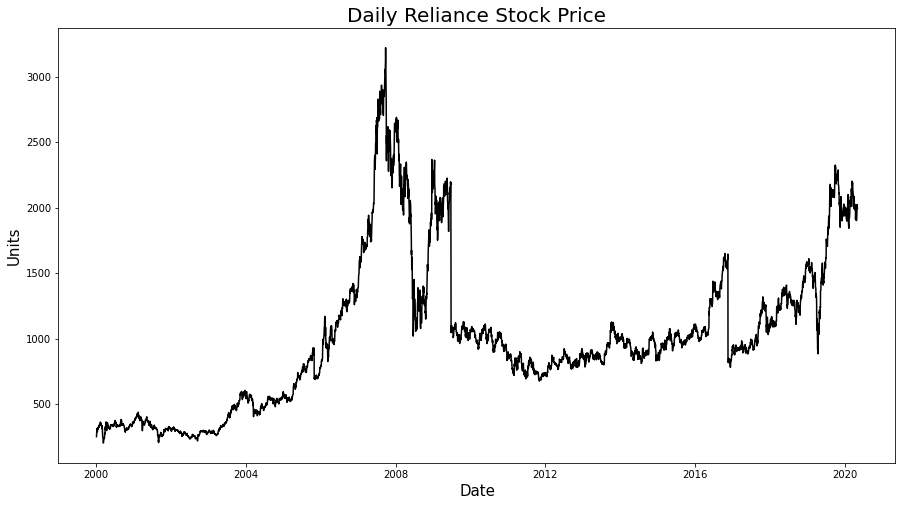

In [12]:
plt.plot(df,color='black')
plt.title('Daily Reliance Stock Price',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [13]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [14]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['Close'] = df['Close'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [15]:
#Split data set into testing dataset and train dataset
train_size = 4775
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 4
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [16]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(4771, 4)
(4771,)
(527, 4)
(527,)


In [17]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 6.1 MB/s 


In [18]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [19]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 7)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value = 256,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [20]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_3')

In [21]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 7, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [22]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=35,
             validation_data=(testX, testY))

Trial 20 Complete [00h 01m 29s]
val_mape: 1.4426426887512207

Best val_mape So Far: 1.4426426887512207
Total elapsed time: 00h 32m 41s
INFO:tensorflow:Oracle triggered exit


In [23]:
tuner.results_summary()

Results summary
Results in project/loa_em_3
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 5
units_0: 32
dropout: False
learning_rate: 0.00010075825959446324
units_1: 208
units_2: 184
units_3: 32
units_4: 144
Dropout_rate: 0.0
units_5: 24
units_6: 32
Score: 1.4426426887512207
Trial summary
Hyperparameters:
num_layers: 6
units_0: 184
dropout: False
learning_rate: 0.00019213248866962183
units_1: 64
units_2: 176
units_3: 72
units_4: 16
Dropout_rate: 0.30000000000000004
units_5: 128
units_6: 224
Score: 1.44302499294281
Trial summary
Hyperparameters:
num_layers: 3
units_0: 144
dropout: False
learning_rate: 2.3134166052581203e-05
units_1: 112
units_2: 128
units_3: 240
units_4: 120
Dropout_rate: 0.2
units_5: 208
units_6: 104
Score: 1.4449113607406616
Trial summary
Hyperparameters:
num_layers: 3
units_0: 208
dropout: False
learning_rate: 3.0719141618681566e-05
units_1: 56
units_2: 224
units_3: 152
units_4: 144
Score: 1.445129990577

In [24]:
from warnings import filterwarnings
filterwarnings('ignore')

In [25]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 208)               6864      
                                                                 
 dense_2 (Dense)             (None, 184)               38456     
                                                                 
 dense_3 (Dense)             (None, 32)                5920      
                                                                 
 dense_4 (Dense)             (None, 144)               4752      
                                                                 
 dense_5 (Dense)             (None, 1)                 145       
                                                                 
Total params: 56,297
Trainable params: 56,297
Non-traina

In [26]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
model = Sequential()
model.add(Dense(32,activation='relu',input_dim = 4))
model.add(Dense(208,activation='relu'))
model.add(Dense(184,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(144,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.0000010075825959446324)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 35, epochs = 300)

Epoch 1/300
137/137 [==============================] - 2s 6ms/step - loss: 96.5295 - mape: 96.5295 - val_loss: 96.1702 - val_mape: 96.1702
Epoch 2/300
137/137 [==============================] - 1s 9ms/step - loss: 95.0929 - mape: 95.0929 - val_loss: 95.1368 - val_mape: 95.1368
Epoch 3/300
137/137 [==============================] - 0s 3ms/step - loss: 93.7353 - mape: 93.7353 - val_loss: 94.1344 - val_mape: 94.1344
Epoch 4/300
137/137 [==============================] - 0s 3ms/step - loss: 92.3965 - mape: 92.3965 - val_loss: 93.1289 - val_mape: 93.1289
Epoch 5/300
137/137 [==============================] - 0s 3ms/step - loss: 90.9900 - mape: 90.9900 - val_loss: 92.0539 - val_mape: 92.0539
Epoch 6/300
137/137 [==============================] - 0s 3ms/step - loss: 89.5152 - mape: 89.5152 - val_loss: 90.9183 - val_mape: 90.9183
Epoch 7/300
137/137 [==============================] - 0s 3ms/step - loss: 87.9560 - mape: 87.9560 - val_loss: 89.7144 - val_mape: 89.7144
Epoch 8/300
137/137 [======

In [29]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [30]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 1.53 
Test MAPE : 1.65 


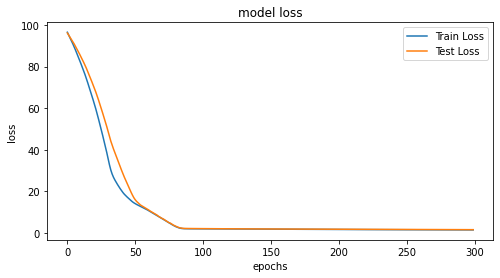

In [31]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [32]:
import seaborn as sns

In [33]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(4771,5298)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

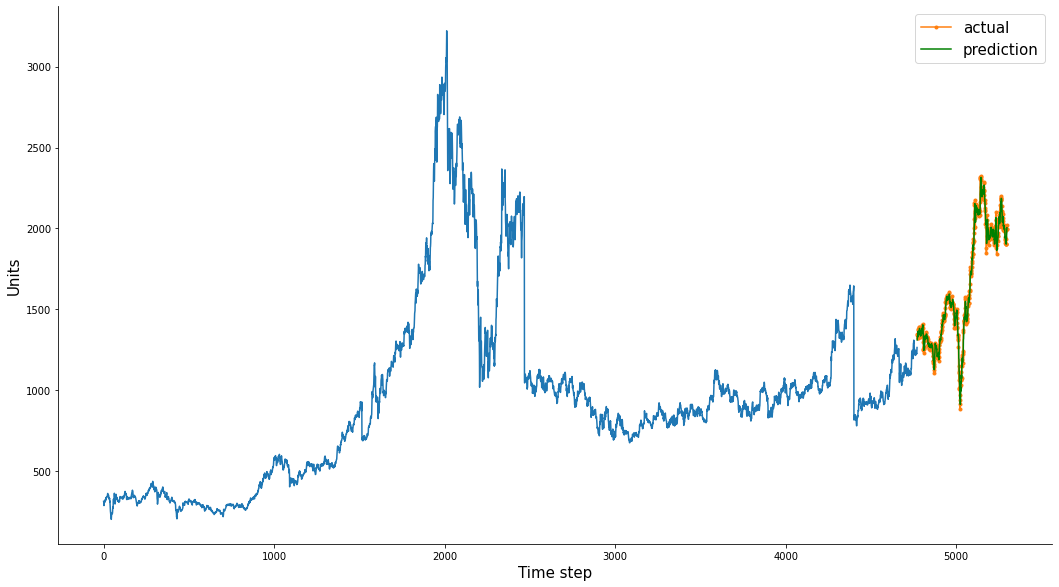

In [34]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)